In [82]:
import os

import bids
import matplotlib.pyplot as plt
import numpy as np

from ghost.misc import ghost_path
from ghost.bids import setup_bids_directories, import_dicom_folder
from ghost.phantom import Caliber137

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BIDS Demo
This short demo will go through some basic usage of the `ghost` python module with data arranged in a BIDS data structure.

## Setup project structure

In [31]:
# Setup directory structure (rawdata and derivatives)
projdir = '.' # Change to appropriate directory
setup_bids_directories(projdir)

In [ ]:
# Import DICOMs. Use the example dataset
config = './dcm2bids_config.json'
dicom_dir = os.path.join(ghost_path(), "example_data/UNITY_QA/DICOM")
sub_name = 'P0004' # For the phantom serial number in this case

# Loop over the sessions
for f in os.listdir(dicom_dir):
    p = os.path.join(dicom_dir, f)
    if os.path.isdir(p):
        import_dicom_folder(dicom_dir=p, sub_name=sub_name, ses_name=f, config=config, projdir=projdir)

Now the `rawdata/` folder contains a BIDS compatible directory (`sub-P0004/`) and a temporary folder (`tmp_dcm2bids`). In the temporary folder we find files that were converted to NIFTI, but couldn't be BIDSified. This can happen for a few reasons. 
1. No match was find with the description criteria in the `dcm2bids_config.json` file. (Here, we're not interested in the localizer image so we couldn't be bothered to include an identifier for it). If you want to practice, go and edit the `dcm2bids_config.json` file and re-run the previous cell until the localizer image is successfully BIDSified.
2. Multiple matches were found for a single description criterion. If this is the case, you can inspect the sidecar file and look for the "SeriesDescription" field for example. It is often a good unique identifier.

For a more comprehensive tutorial, check [this](https://unfmontreal.github.io/Dcm2Bids/docs/tutorial/first-steps/) out.

## Query the BIDS layout

In [40]:
layout = bids.BIDSLayout(root=f'{projdir}/rawdata', derivatives=f'{projdir}/derivatives')

# We use the .get command to get files. Example all first runs for the T2w scans
t2w_axi1 = layout.get(scope='raw', extension='.nii.gz', suffix='T2w', reconstruction='axi', run=1)

all_fisp = layout.get(scope='raw', extension='.nii.gz', suffix='PDw', acquisition='temperature')

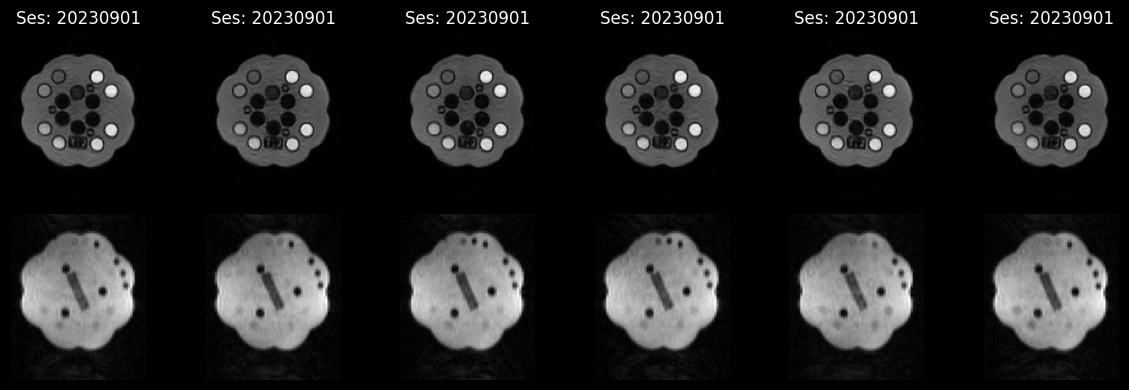

In [66]:
plt.style.use('dark_background')
fig, axes = plt.subplots(2,6,figsize=(12,4))

for i in range(len(t2w_axi1)):
    img = t2w_axi1[i].get_image().get_fdata()
    axes[0,i].imshow(np.rot90(img[:,:,14]), cmap='gray'); axes[0,i].axis('off')
    ent = f.get_entities()
    axes[0,i].set_title(f'Ses: {ent["session"]}')

    img = all_fisp[i].get_image().get_fdata()
    axes[1,i].imshow(np.rot90(img[:,:,21]), cmap='gray'); axes[1,i].axis('off')
    
plt.tight_layout()
plt.show()

## Automated analysis on BIDS layout

In [83]:
import ghost.bids as gbids

In [ ]:
sessions = layout.get_sessions()

phantom = Caliber137()
sub = 'P0004'

for ses in sessions:
    print(f"------ {ses} ------")
    # Get the files we want to process
    axi1 = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='axi', session=ses, run=1)[0]
    axi2 = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='axi', session=ses, run=2)[0]
    sag = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='sag', session=ses)[0]
    cor = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='cor', session=ses)[0]
    fisp = layout.get(scope='raw', extension='.nii.gz', subject=sub, suffix='PDw', session=ses)[0]
    
    mimics = ['T1mimics', 'T2mimics', 'ADC']
    all_masks = [*mimics, 'LC', 'phantomMask']
    all_t2 = [axi1, axi2, sag, cor]

    # Warp the masks
    for img in all_t2:
        gbids.reg_img(layout, img, phantom, ow=False)
    
    layout = gbids._update_layout(layout)
    for img in all_t2:
        for mask in all_masks:
            gbids.warp_mask(layout, img, mask, phantom, xfm_type='Rigid', ow=False)

    layout = gbids._update_layout(layout)
    for img in [axi1, axi2]:
        for mask in mimics:
            gbids.refine_mimics_2D_axi(layout, img, mask, phantom, ow=False)

    layout = gbids._update_layout(layout)
    for img in [axi1, axi2]:
        for mask in mimics:
            gbids.get_intensity_stats(layout, img, f"seg{mask}", ow=False)
    
    for img in all_t2:
        gbids.segment_fiducials(layout, img, device='cpu')

    # layout = gbids._update_layout(layout)
    # for img in all_t2:
        # get_fiducials(layout, img, phantom, ow=False)
    
    # for img in [axi1, axi2, sag, cor]:
        # _logprint(img.filename)
        # get_fiducial_positions2(layout, img, phantom, out_stat='FidPosUNet', input_desc='segFidLabelsUNet', aff_fname='FidPointUNetAffine', ow=True)
    
    gbids.calc_runs_psnr(layout, axi1, ow=True)

The results are now written to the derivatives directory.

_More tools for visualization will be added soon._